# IMPORT

In [1]:
!pip install seaborn==0.10.1
!pip install -U scikit-learn

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-learn in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (0.23.1)
Requirement not upgraded as not directly required: numpy>=1.13.3 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.14.6)
Requirement not upgraded as not directly required: joblib>=0.11 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (0.15.1)
Requirement not upgraded as not directly required: threadpoolctl>=2.0.0 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (2.1.0)
Requirement not upgraded as not directly required: scipy>=0.19.1 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.1.0)
You are using pip ve

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import re
from pathlib import Path

# magic word for producing visualizations in notebook
%matplotlib inline

# CUSTOM FUNCTIONS

# DATA STORAGE TO S3

In [24]:
import sagemaker
session = sagemaker.session.Session
bucket = 'auto-ml-exploration'

In [13]:
s3_dataset_path = f's3://{bucket}/dataset'

sagemaker.s3.S3Uploader.upload('Udacity_AZDIAS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_CUSTOMERS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TEST.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TRAIN.csv', s3_dataset_path)

# LOAD DATA

## Data location

In [25]:
# data location on S3
pop_dataset_loc = f's3://{bucket}/dataset/Udacity_AZDIAS_052018.csv'
customers_dataset_loc = f's3://{bucket}/dataset/Udacity_CUSTOMERS_052018.csv'

## Partial loading

In [26]:
# partial loading
# load in the data, first only a few rows to get an idea
# I had a memory issue when loading the complete file
# 1 every 2 rows
pop_df_partial = pd.read_csv(pop_dataset_loc, sep=';', skiprows = lambda x: x%2) # skiprows because much data... Let's see if one can convert some to categorical to reduce memory usage

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
customers_df_partial = pd.read_csv(customers_dataset_loc, sep=';', skiprows = lambda x: x%2)

## Mini loading

In [ ]:
pop_df_mini = pop_df_partial.iloc[0:100,:]
customers_df_partial = customers_df_partial.iloc[0:100,:]

## Full loading

In [ ]:
pop_df = pd.read_csv(pop_dataset_loc, sep=';', dtype = cat_col)
cat_col_customers = cat_col.copy()
cat_col_customers['CUSTOMER_GROUP'] = 'category'
cat_col_customers['ONLINE_PURCHASE'] = 'category'
cat_col_customers['PRODUCT_GROUP'] = 'category'

customers_df = pd.read_csv(customers_dataset_loc, sep=';', dtype = cat_col_customers)

## Data selection

### Pickle

In [7]:
pop_df_selected = pd.read_pickle('pop_df_exploration.pkl')

In [8]:
pop_df_selected = pop_df_selected.iloc[:100,:]

In [ ]:
customers_df_selected = pd.read_pickle('customers_df_exploration.pkl')

### Other

In [27]:
pop_df_selected = pop_df_partial

In [6]:
customers_df_selected = customers_df_partial

## Save to pickle to save time next time

In [10]:
if not Path('pop_df_exploration.pkl').exists():
    pop_df_selected.to_pickle('pop_df_exploration.pkl')
if not Path('customers_df_exploration.pkl').exists():
    pop_df_selected.to_pickle('customers_df_exploration.pkl')

# Explore Data - population

## Make better index

In [14]:
pop_df_selected.set_index('LNR', inplace=True)

## General statistics

In [253]:
pop_df_selected.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0
910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,0.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1.0,1.0,1.0
645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,0.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4.0,2.0,3.0


In [206]:
pop_df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363212 entries, 0 to 363211
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(289), int64(71), object(6)
memory usage: 1014.2+ MB


In [5]:
pop_df_selected.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,3.632120e+05,363212.000000,333574.000000,333574.000000,33147.000000,12166.000000,2547.000000,501.000000,256099.000000,325550.000000,...,313999.000000,332579.000000,332579.000000,332579.000000,319597.000000,333573.000000,325549.000000,363211.000000,363211.000000,363211.000000
mean,6.366678e+05,-0.359198,4.427036,10.858295,11.739132,13.444764,14.555556,15.051896,13.705383,8.267182,...,2.420610,6.004528,7.537704,5.952147,3.929643,7.910367,4.048011,3.359160,1.522184,2.776491
std,2.558490e+05,1.198028,3.639139,7.644164,4.085674,3.248806,2.643738,2.444034,5.078172,15.597372,...,1.165968,2.857556,3.249021,2.773321,1.964833,1.922841,1.950010,1.355002,0.499508,1.068990
min,1.916550e+05,-1.000000,1.000000,0.000000,2.000000,3.000000,5.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.159545e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.334155e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.575152e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


## Analyze missing values (np.nan)

In [5]:
nan_counts = pop_df_selected.isnull().sum().sort_values(ascending=False)

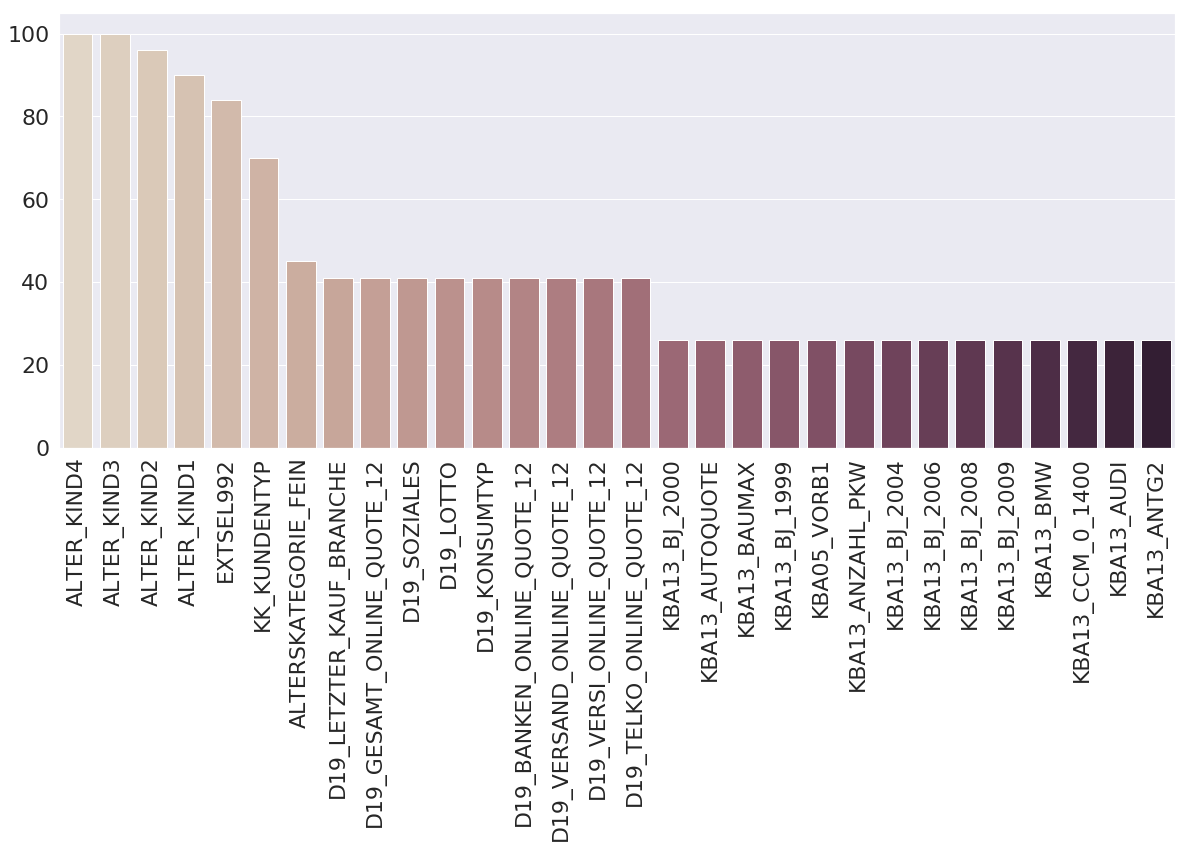

In [9]:
top_ = 30
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x = nan_counts.index[:top_], y = nan_counts.values[:top_],
                  palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
fig = g.get_figure()
#fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

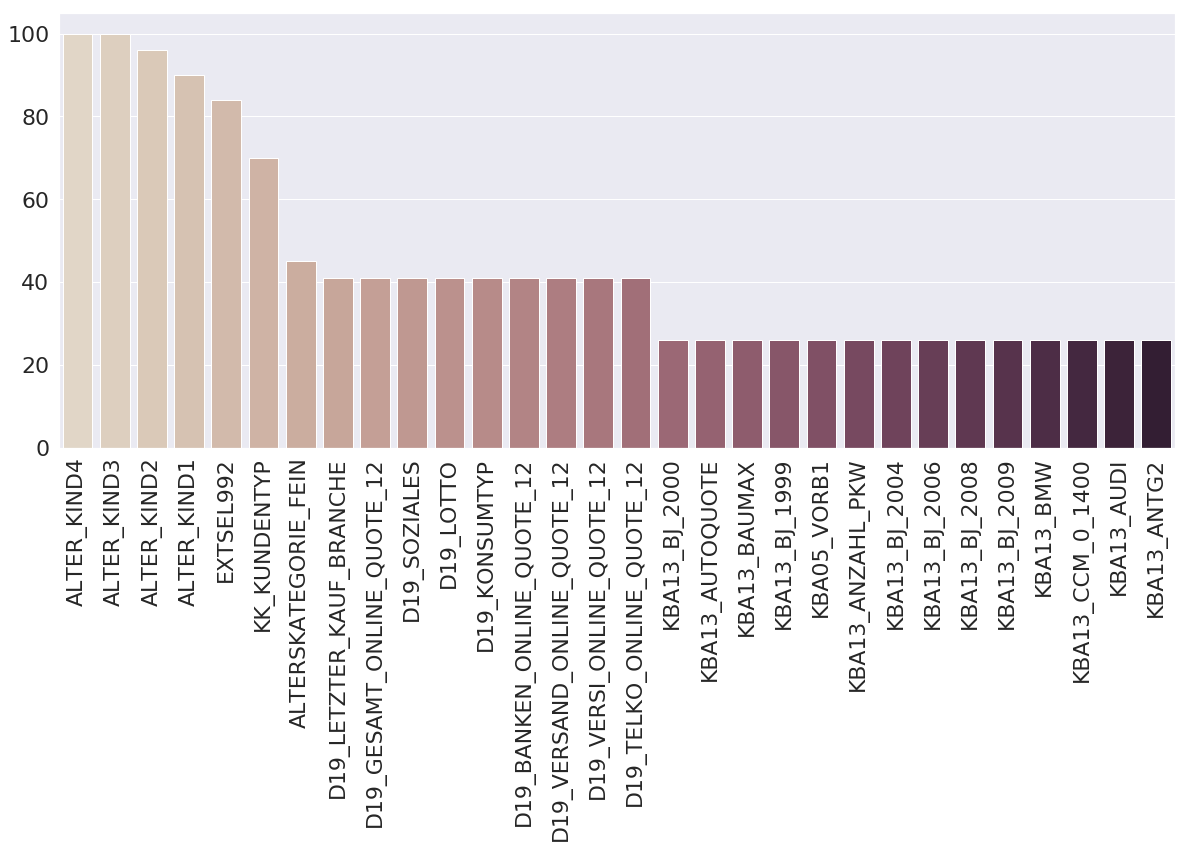

In [8]:
# the same in percent
top_ = 30
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x = nan_counts.index[:top_], y = nan_counts.values[:top_]/pop_df_selected.shape[0]*100,
                  palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
fig = g.get_figure()
#fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

# one sees a significant drop between 6th first columns and the rest
# a ratio of nan around 65% should do it

## let's analyze the frequency of categories inside each column (most columns are categorical)

In [11]:
plt.ioff()
IMG_DIR = Path('img/exploration/frequency')
IMG_DIR.mkdir(exist_ok=True, parents=True)
for col in pop_df_selected.columns:
    x_labels = list(pop_df_selected[col].index)
    sns.set(font_scale=2)
    f, ax = plt.subplots(figsize=(10,5))
    series = pop_df_selected.loc[:,col].fillna('none').value_counts(normalize=True) # fillna is mandatory since seaborn discards np.nan
    try:
        g = sns.barplot(x = list(series.index) , y= series.values, 
                        palette="ch:.25", )
    except Exception:
        print(series)
        break
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    fig = g.get_figure()
    fig.savefig(IMG_DIR.joinpath(f'frequency_{col}'))

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# Explora cleaned data - population

In [12]:
pop_df_selected = pd.read_pickle('pop_df_cleaned_with_nan.pkl')

In [17]:
pop_df_selected.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910220,NaN,9.0,NaN,21.0,11.0,0.0,0.0,2.0,0.0,3.0,...,3.0,1.0,0.0,0.0,4.0,3.0,9.0,4.0,5.0,1.0
910226,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,0.0,2.0,...,5.0,0.0,0.0,1.0,0.0,NaN,9.0,7.0,3.0,4.0
910244,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,0.0,2.0,...,3.0,0.0,0.0,0.0,2.0,6.0,9.0,7.0,4.0,1.0
910261,NaN,1.0,14.0,14.0,6.0,0.0,0.0,1.0,0.0,2.0,...,4.0,0.0,3.0,0.0,2.0,5.0,9.0,1.0,1.0,1.0
645153,NaN,5.0,17.0,17.0,9.0,0.0,0.0,1.0,0.0,2.0,...,5.0,0.0,23.0,0.0,4.0,4.0,3.0,7.0,4.0,3.0


## Let's see missing values

In [13]:
nan_counts = pop_df_selected.isnull().sum().sort_values(ascending=False)

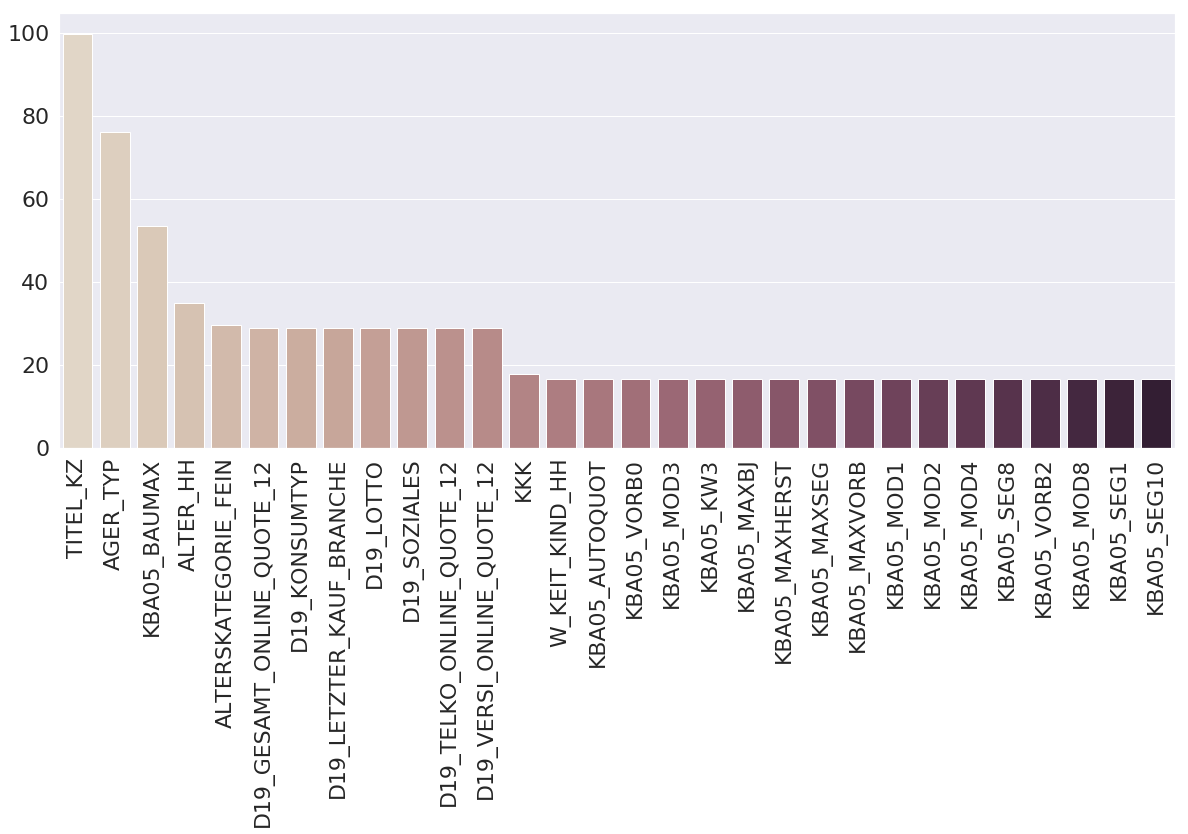

In [18]:
# the same in percent
top_ = 30
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20,8))
g = sns.barplot(x = nan_counts.index[:top_], y = nan_counts.values[:top_]/pop_df_selected.shape[0]*100,
                  palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
fig = g.get_figure()
plt.show()
#fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

# one sees that TITEL_KZ contained almost only nan equivalent that were identified during cleaning steps
# also, AGER_TYP & KBA05_BAUMAX contained significant (>50%) amount of nan equivalent

In [26]:
df1

,class,survived,percent
0,First,1,62.962963
1,First,0,37.037037
2,Second,0,52.717391
3,Second,1,47.282609
4,Third,0,75.763747
5,Third,1,24.236253


In [22]:
pop_df_selected[col].value_counts(normalize=True).rename('percent')

-1    0.81
 2    0.09
 1    0.09
 3    0.01
Name: percent, dtype: float64

In [213]:
for col in pop_df_selected.columns:
    print(f'there are {pop_df_selected[col].nunique()} values in column {col}')

there are 5 values in column AGER_TYP
there are 9 values in column AKT_DAT_KL
there are 21 values in column ALTER_HH
there are 17 values in column ALTER_KIND1
there are 16 values in column ALTER_KIND2
there are 14 values in column ALTER_KIND3
there are 12 values in column ALTER_KIND4
there are 25 values in column ALTERSKATEGORIE_FEIN
there are 275 values in column ANZ_HAUSHALTE_AKTIV
there are 20 values in column ANZ_HH_TITEL
there are 9 values in column ANZ_KINDER
there are 24 values in column ANZ_PERSONEN
there are 252 values in column ANZ_STATISTISCHE_HAUSHALTE
there are 5 values in column ANZ_TITEL
there are 6 values in column ARBEIT
there are 7 values in column BALLRAUM
there are 45 values in column CAMEO_DEU_2015
there are 19 values in column CAMEO_DEUG_2015
there are 43 values in column CAMEO_INTL_2015
there are 6 values in column CJT_GESAMTTYP
there are 5 values in column CJT_KATALOGNUTZER
there are 5 values in column CJT_TYP_1
there are 5 values in column CJT_TYP_2
there are 5

there are 3 values in column KBA13_ANTG4
there are 1259 values in column KBA13_ANZAHL_PKW
there are 5 values in column KBA13_AUDI
there are 6 values in column KBA13_AUTOQUOTE
there are 5 values in column KBA13_BAUMAX
there are 5 values in column KBA13_BJ_1999
there are 5 values in column KBA13_BJ_2000
there are 5 values in column KBA13_BJ_2004
there are 5 values in column KBA13_BJ_2006
there are 6 values in column KBA13_BJ_2008
there are 6 values in column KBA13_BJ_2009
there are 5 values in column KBA13_BMW
there are 6 values in column KBA13_CCM_0_1400
there are 6 values in column KBA13_CCM_1000
there are 6 values in column KBA13_CCM_1200
there are 5 values in column KBA13_CCM_1400
there are 5 values in column KBA13_CCM_1401_2500
there are 5 values in column KBA13_CCM_1500
there are 5 values in column KBA13_CCM_1600
there are 6 values in column KBA13_CCM_1800
there are 5 values in column KBA13_CCM_2000
there are 6 values in column KBA13_CCM_2500
there are 6 values in column KBA13_CCM_

In [254]:
high_unique = []
for col in (set(pop_df_selected.columns) - set(col_numeric)):
    if pop_df_selected[col].nunique() > 10:
        high_unique.append(col)
        print(f'Column {col} is considered featuring a high number of unique values. {pop_df_selected[col].nunique()} unique values are identified')

Column VK_DHT4A is considered featuring a high number of unique values. 11 unique values are identified
Column VERDICHTUNGSRAUM is considered featuring a high number of unique values. 46 unique values are identified
Column EINGEFUEGT_AM is considered featuring a high number of unique values. 4274 unique values are identified
Column VK_DISTANZ is considered featuring a high number of unique values. 13 unique values are identified
Column ALTER_KIND4 is considered featuring a high number of unique values. 12 unique values are identified
Column LP_FAMILIE_FEIN is considered featuring a high number of unique values. 12 unique values are identified
Column PRAEGENDE_JUGENDJAHRE is considered featuring a high number of unique values. 16 unique values are identified
Column ANZ_STATISTISCHE_HAUSHALTE is considered featuring a high number of unique values. 252 unique values are identified
Column GFK_URLAUBERTYP is considered featuring a high number of unique values. 12 unique values are identifie

In [255]:
# let's see if we can discard low occurence
threshold = 0.02 # fraction
for col in pop_df_selected.columns:
    tot_values = pop_df_selected[col].shape[0]
    value_counts = pop_df_selected[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts/tot_values <= threshold].index
    pop_df_selected[col] = pop_df_selected[col].replace(to_remove, np.nan)

In [257]:
high_unique2 = []
for col in (set(pop_df_selected.columns) - set(col_numeric)):
    if pop_df_selected[col].nunique() > 10:
        high_unique2.append(col)
        print(f'Column {col} is considered featuring a high number of unique values. {pop_df_selected[col].nunique()} unique values are identified')

Column VK_DISTANZ is considered featuring a high number of unique values. 13 unique values are identified
Column PRAEGENDE_JUGENDJAHRE is considered featuring a high number of unique values. 13 unique values are identified
Column ANZ_STATISTISCHE_HAUSHALTE is considered featuring a high number of unique values. 11 unique values are identified
Column GFK_URLAUBERTYP is considered featuring a high number of unique values. 12 unique values are identified
Column CAMEO_INTL_2015 is considered featuring a high number of unique values. 14 unique values are identified
Column ALTER_HH is considered featuring a high number of unique values. 14 unique values are identified
Column ALTERSKATEGORIE_FEIN is considered featuring a high number of unique values. 13 unique values are identified
Column EINGEZOGENAM_HH_JAHR is considered featuring a high number of unique values. 22 unique values are identified
Column LP_LEBENSPHASE_FEIN is considered featuring a high number of unique values. 18 unique valu

In [247]:
pop_df_selected.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910220,-1.0,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,4.0,NaN,NaN,10.0,3.0,9.0,4.0,NaN,2.0,1.0
910226,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,NaN,7.0,10.0,NaN,NaN,9.0,7.0,3.0,2.0,4.0
910244,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,2.0,10.0,NaN,NaN,6.0,9.0,7.0,4.0,2.0,1.0
910261,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,2.0,10.0,NaN,NaN,NaN,9.0,NaN,1.0,1.0,1.0
645153,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,4.0,NaN,NaN,NaN,4.0,NaN,7.0,4.0,2.0,3.0


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


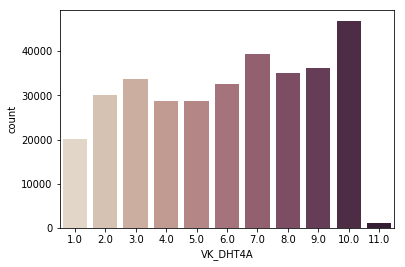

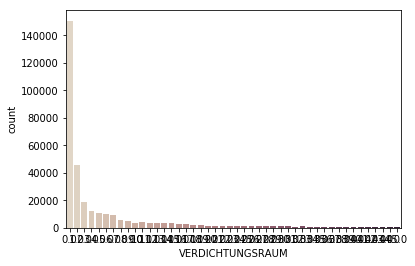

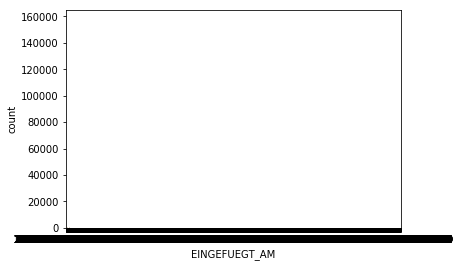

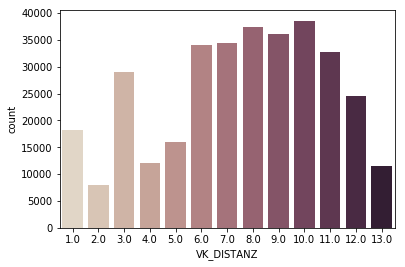

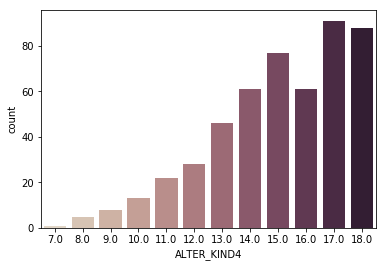

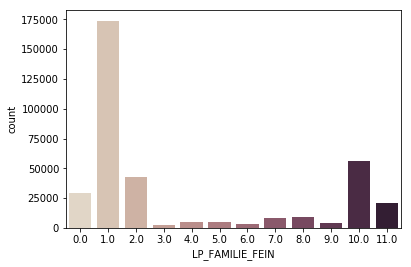

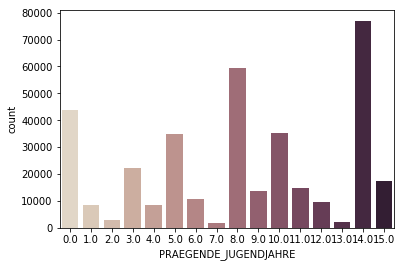

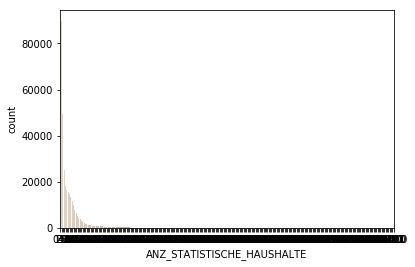

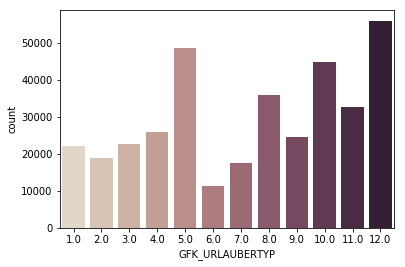

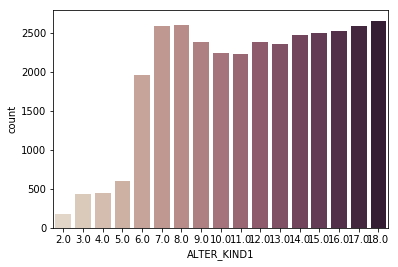

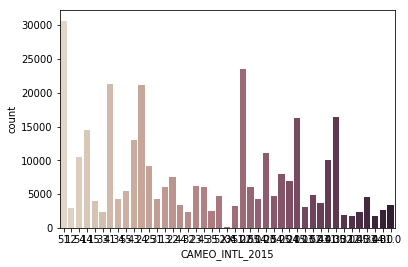

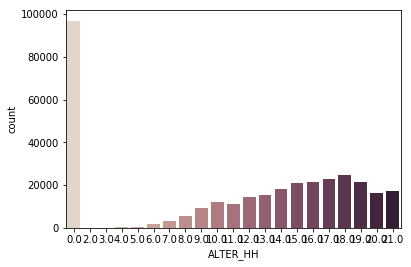

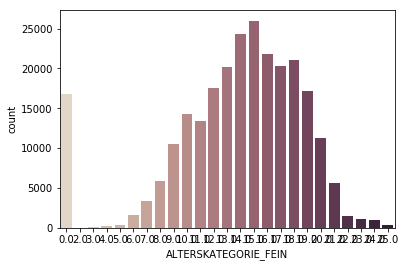

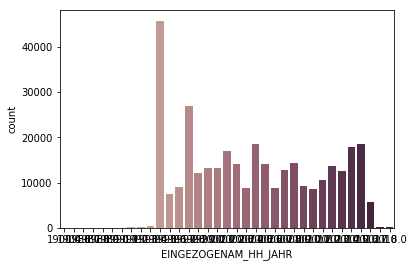

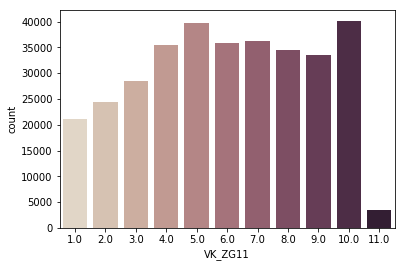

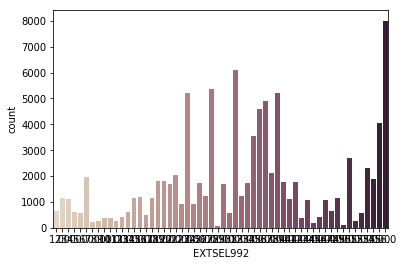

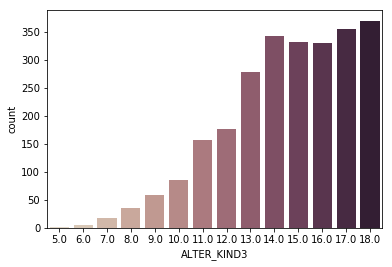

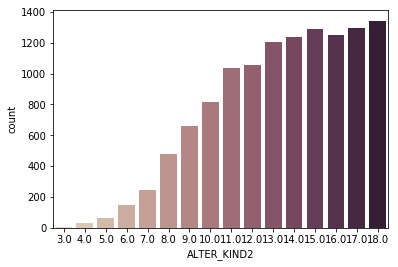

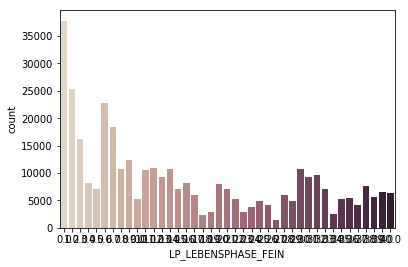

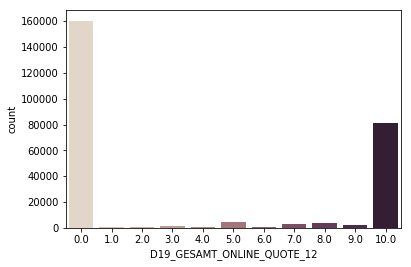

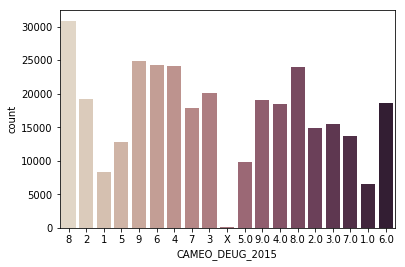

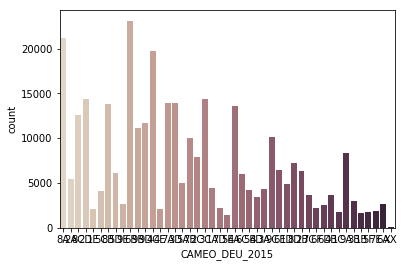

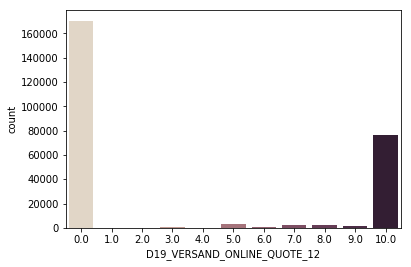

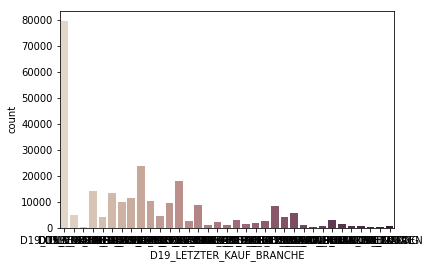

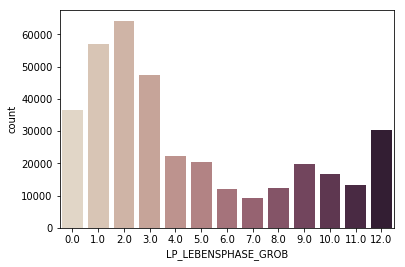

In [241]:
for col in high_unique:
    f, ax = plt.subplots()
    g = sns.countplot(x=col, 
                    data=pop_df_selected, 
                    palette="ch:.25")
    fig = g.get_figure()
    fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

In [18]:
(pop_df_selected==0).sum().sum()

22722227

In [19]:
(pop_df_selected=='0').sum().sum()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0

# Experiments

In [5]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import re
from pathlib import Path

# magic word for producing visualizations in notebook
%matplotlib inline

In [239]:
col_numeric = identify_numeric(filename, copy)